In [69]:
import os

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

out_dir = "../../data/05_reporting/problem_set_2"

In [64]:
# helper functions

def load_data(fpath: str | os.PathLike = "../../data/01_raw/penguins.csv"
              ) -> pd.DataFrame:
    return pd.read_csv(fpath)

def plot_priors(model, n_prior_vals=100) -> None:
    plt_dict = {
        r'$\alpha$ prior': model.alpha_prior,
        r'$\beta$ prior': model.beta_prior,
        r'$\sigma$ prior': model.sigma_prior
    }

    fig, axs = plt.subplots(ncols=len(plt_dict), figsize=(15, 5))
    
    for (k, v), ax in zip(plt_dict.items(), axs):
        dist = v.rvs(n_prior_vals)
        labs = v.kwds
        ax.hist(dist, label=labs)
        ax.set_title(k)
        ax.legend()    

def plot_prior_predictive(model, X):
    X_tilde, y_tilde, alpha, beta = model.simulate_prior_predictive(X)

    fig, axs = plt.subplots(ncols=2, figsize= (12, 5))
    
    ax = axs[0]
    ax.hist(y_tilde)
    ax.set_xlabel(r'$\tilde{y}$')

    ax = axs[1]

    ax.set_xlim(-50, 50)

    for i in range(len(alpha)):
        xy1 = (0, alpha[i])
        slope = beta[i]

        ax.axline(xy1=xy1, slope=slope, alpha=.05)

    ax.axvline(x=0, color='black', linestyle='--')
    ax.axhline(y=0, color='black', linestyle='--')
    ax.set_xlabel(r'$\mu = \alpha + \beta(\tilde{X})$') 

# Question 3

## 3.1

In [4]:
df = load_data()
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE
...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214,4925,FEMALE
338,Gentoo,Biscoe,46.8,14.3,215,4850,FEMALE
339,Gentoo,Biscoe,50.4,15.7,222,5750,MALE
340,Gentoo,Biscoe,45.2,14.8,212,5200,FEMALE


In [5]:
our_penguin = "Gentoo"
gentoo = df[df['species'] == our_penguin]

## 3.2

In [91]:
class PenguinModel():

    def __init__(self):
        self.alpha_prior = self.assign_alpha_prior()
        self.beta_prior = self.assign_beta_prior()
        self.sigma_prior = self.assign_sigma_prior()
        self.likelihood = None

    # define model attributes
    def assign_alpha_prior(self, loc: float=3.0, scale: float=2.0):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_beta_prior(self, loc: float=0.1, scale: float=0.2):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_sigma_prior(self, s: float=1, scale: float=0):
        return sp.stats.lognorm(s=s, scale=np.exp(scale))

    def assign_likelihood(self, loc, scale):
        mod = sp.stats.norm(loc=loc, scale=scale)
        self.likelihood = mod
        
    # define methods
    def bootstrap(self, X, stat=np.mean, n_resamples: int=1000,
            random_state=np.random.default_rng()
    ) -> np.array:
        res = sp.stats.bootstrap(X, 
                                 stat, 
                                 random_state=random_state,
                                 n_resamples=n_resamples)
        return res.bootstrap_distribution
    
    def simulate_prior_predictive(self, X):
        X_hat = self.bootstrap((X, ))

        n_prior_samples = len(X_hat)

        alpha = self.alpha_prior.rvs(size=n_prior_samples)
        beta = self.beta_prior.rvs(size=n_prior_samples)
        sigma = self.sigma_prior.rvs(size=n_prior_samples)
        mu = alpha + beta * X_hat

        self.assign_likelihood(loc=mu, scale=sigma)
        y_tilde = self.likelihood.rvs(size=n_prior_samples)

        return X, y_tilde, alpha, beta

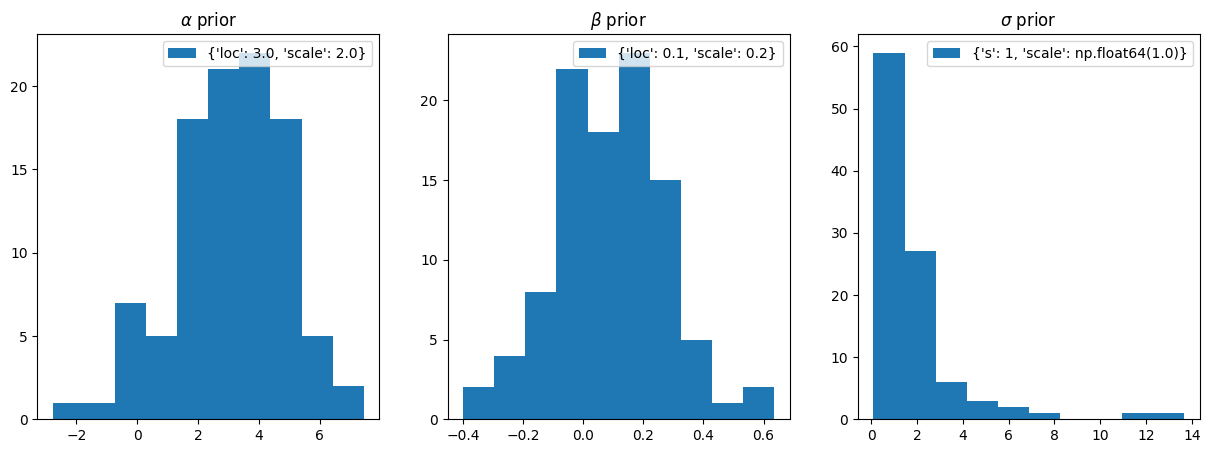

In [92]:
n_prior_vals = 100
model = PenguinModel()
plot_priors(model, n_prior_vals)
plt.savefig(os.path.join(out_dir, 'prior_distributions.pdf'), bbox_inches='tight')

(array([   9.,   97.,  486., 1627., 2808., 2851., 1567.,  475.,   69.,
          10.]),
 array([-135.60406538, -103.85399831,  -72.10393125,  -40.35386419,
          -8.60379712,   23.14626994,   54.896337  ,   86.64640407,
         118.39647113,  150.14653819,  181.89660526]),
 <BarContainer object of 10 artists>)

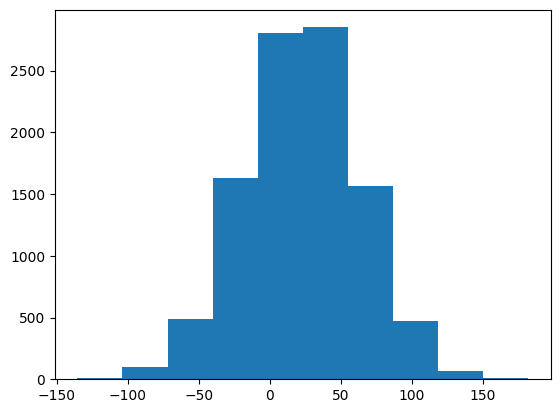

In [93]:
plot_prior_predictive(model, df['flipper_length_mm'])
plt.savefig(os.path.join(out_dir, 'prior_predictive.pdf'), bbox_inches='tight')

# Exercise 4 #

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pandas as pd
import networkx as nx
from collections import Counter
sns.set_style('ticks')
%matplotlib inline

In [3]:
def create_Z_support(support_size=10, vec_length=10):
    
    Z = np.random.randint(2, size=(vec_length, support_size))
    return Z

Z = create_Z_support()
print(Z)

[[0 1 0 1 1 0 1 1 1 1]
 [0 1 0 0 1 0 0 0 0 1]
 [1 1 1 1 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 1 1 0]
 [0 0 1 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 1 1 0 0]
 [0 0 0 1 0 0 0 1 0 0]
 [0 0 1 1 1 1 0 0 1 0]
 [1 1 0 0 1 1 0 1 0 1]
 [1 0 0 1 1 0 0 0 1 1]]


In [130]:
# 4.1 - Proposal Distribution P
from sklearn.preprocessing import normalize
def create_proposal_distr_P(support_size=10, vec_length=10):
    
    # Create P and normalize
    P = np.random.random(support_size*vec_length).reshape(vec_length,support_size).astype(np.float64)
    P /= P.sum(axis=0, keepdims=True) 
   
    return P

P = create_proposal_distr_P(support_size=10, vec_length=10)
print(P)


[[0.1155918  0.00049629 0.1190931  0.16147018 0.09874042 0.15180285
  0.05519008 0.01969572 0.11597777 0.11159228]
 [0.08277364 0.01323138 0.01460417 0.07516773 0.1364186  0.0478515
  0.07886652 0.13583832 0.20774835 0.1548806 ]
 [0.07464201 0.07401089 0.07520308 0.13284853 0.16111519 0.02391477
  0.0876674  0.15498653 0.04349298 0.08830741]
 [0.06684856 0.05525289 0.03028473 0.08288321 0.07821797 0.03471713
  0.10965139 0.05281524 0.13848904 0.04742487]
 [0.12668439 0.18015807 0.11179382 0.1060608  0.09498175 0.16739508
  0.10997121 0.12334701 0.0961516  0.0082735 ]
 [0.10752139 0.16706687 0.124327   0.15260919 0.10008839 0.06629875
  0.01246075 0.05952673 0.07805815 0.03128552]
 [0.10478048 0.15800472 0.18118759 0.03096707 0.15742845 0.17773733
  0.1442093  0.06721926 0.02688088 0.05639352]
 [0.10347659 0.02741231 0.07769521 0.18327139 0.0942492  0.12105825
  0.14284796 0.1701123  0.00706573 0.21034817]
 [0.08162241 0.17676206 0.10062867 0.00471331 0.01616378 0.05902062
  0.17464173 

In [162]:

def propose_next_state(Z, P, init_state):
    """
        Return a proposed move move based on current state.

        Parameters
        ----------
            
        Z : np.array
            The matrix of z support vectors.
            
        P : np.array
            The matrix of transition probabilities. Normalized by columns.
            
        init_state : int
            The current state, stored as the row index wrt Z support
            
        Returns
        --------
        
        next_state_row: np.array
            The next states, stored as the vector given by the support Z
            
        next_state_row_idx: int
            The next state, stored as the row index wrt Z support 
        
    """
    
    # states are represented by integers indexed at 0, stored in STATE_SPACE
    next_state_row_idx = np.random.choice(Z.shape[0], p=P[:, init_state])
    next_state_row = Z[next_state_row_idx, :]
    return next_state_row, next_state_row_idx



In [160]:
def metropolis_hastings(support_size, vec_length, T=1000):
    """Run the MH algorithm"""
    
    # Create the support Z
    Z = create_Z_support(support_size, vec_length)
    P = create_proposal_distr_P(support_size, vec_length)
    
    # Init State
    proposed_state_idx = 0
    init_state, init_state_idx = propose_next_state(Z, P, init_state=int(proposed_state_idx))
    
    # Trackers
    states = []
    prob_accumulator = []
    states.append((init_state, init_state_idx))
    
    for t in range(T):
        # Sample state
        i_state, i_state_idx = states[-1]
        i_sum = np.sum(i_state)
  
        # generate proposal
        j_state, j_state_idx = propose_next_state(Z, P, i_state_idx)
        j_sum = np.sum(j_state)
    
        # calculate acceptance prob.
        A = min(1, (P[i_state_idx, j_state_idx] * j_sum) / (P[j_state_idx, i_state_idx] * i_sum))
        
        # Transition threshold
        t_rand  = np.random.rand()

        if t_rand < A:
            # accept
            states.append((j_state, j_state_idx))
            
            # store result
            prob_accumulator.append(j_state_idx)
        else:
            states.append((i_state, i_state_idx))
            
            # store result
            prob_accumulator.append(i_state_idx)
            

    return Z, P, states, prob_accumulator

time_steps = 1000
support_size = 10
vec_length = 10
Z, P, states, prob_accumulator = metropolis_hastings(support_size, vec_length, time_steps)
states_idx = [idx for _, idx in states]
states_lists = [state for state, _ in states]


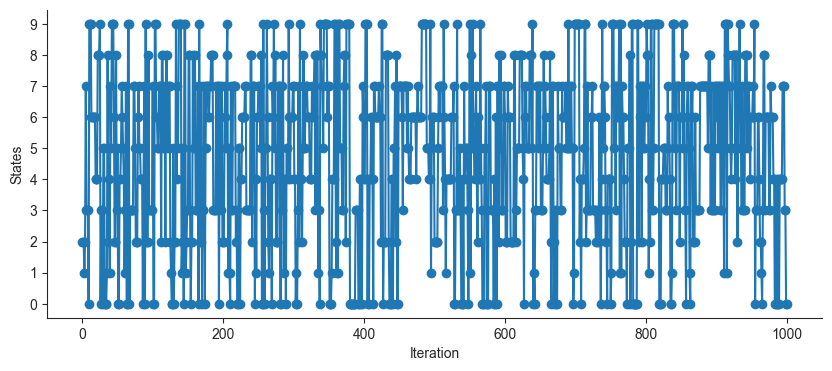

In [164]:
def plot_walk(samples):
    plt.figure(figsize=(10,4))
    plt.plot(samples, marker='o')
    ticks = np.arange(0, 10, 1)
    plt.yticks(ticks)
    sns.despine()
    plt.xlabel('Iteration')
    plt.ylabel('States')

plot_walk(states_idx)

In [163]:
def calc_prob_over_8(accumulator, states_lists, time_steps):
    for i in range(Z.shape[0]):
        
        print(f"State {i} was proposed {(Counter(accumulator)[i] / time_steps * 100):.2f}% of the time")
        
    states_over = [states for states in states_lists if np.sum(states) > 8]
    over_8 = (len(states_over) / time_steps) * 100
    
    print(f"\nProbability of P(Z=z) > 8: {over_8:.2f}%")
        
        
calc_prob_over_8(prob_accumulator, states_lists, time_steps)

State 0 was proposed 11.50% of the time
State 1 was proposed 3.10% of the time
State 2 was proposed 8.00% of the time
State 3 was proposed 12.60% of the time
State 4 was proposed 9.60% of the time
State 5 was proposed 10.60% of the time
State 6 was proposed 11.10% of the time
State 7 was proposed 16.50% of the time
State 8 was proposed 6.90% of the time
State 9 was proposed 10.10% of the time

Probability of P(Z=z) > 8: 0.00%


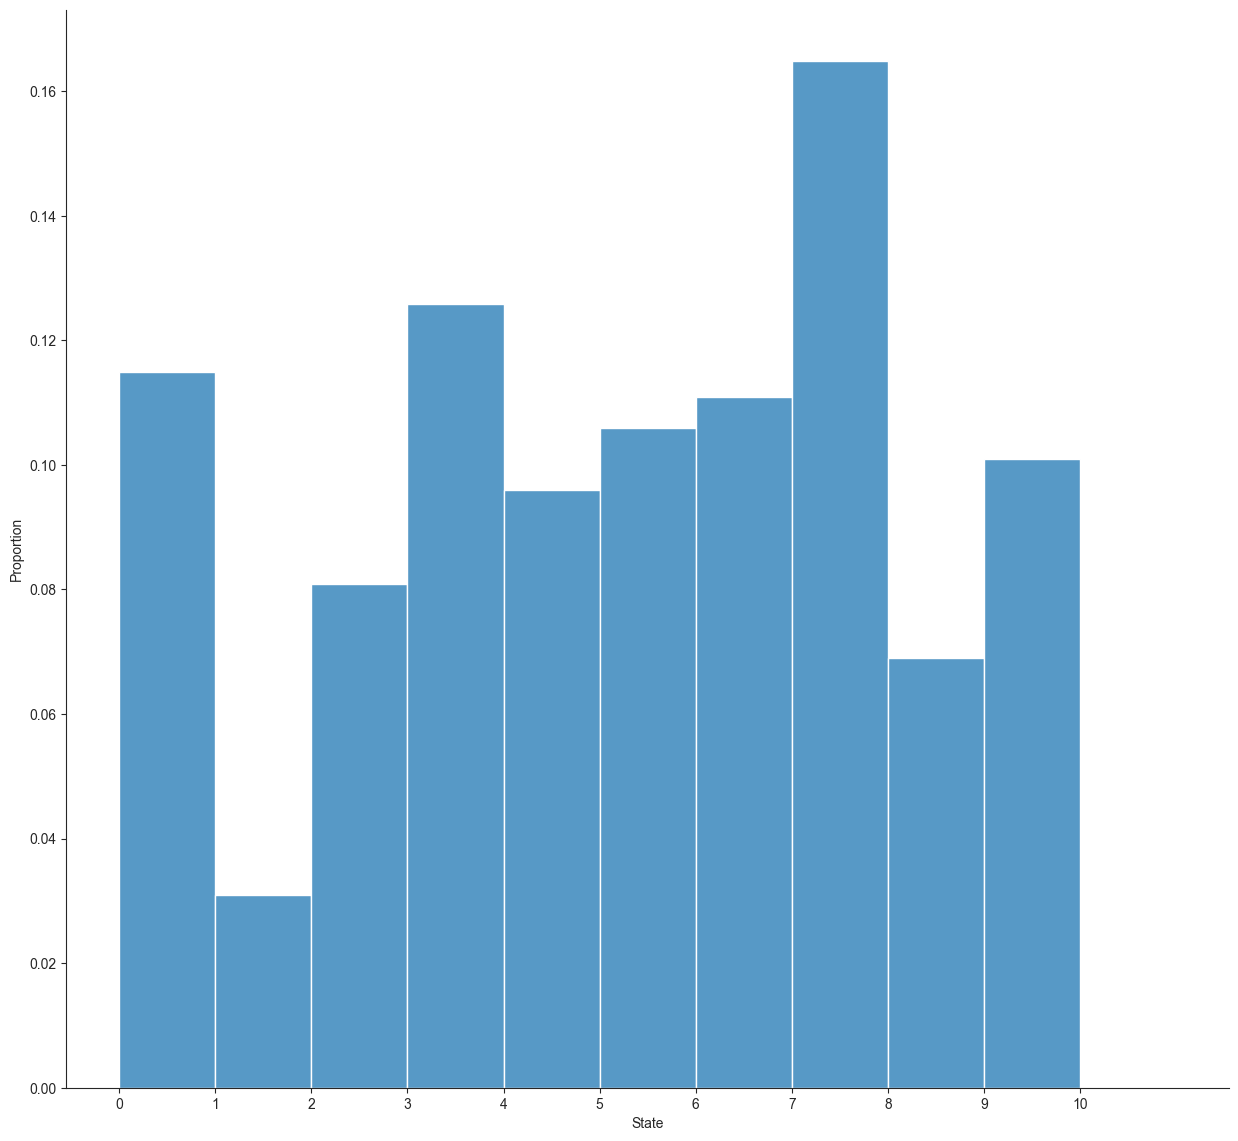

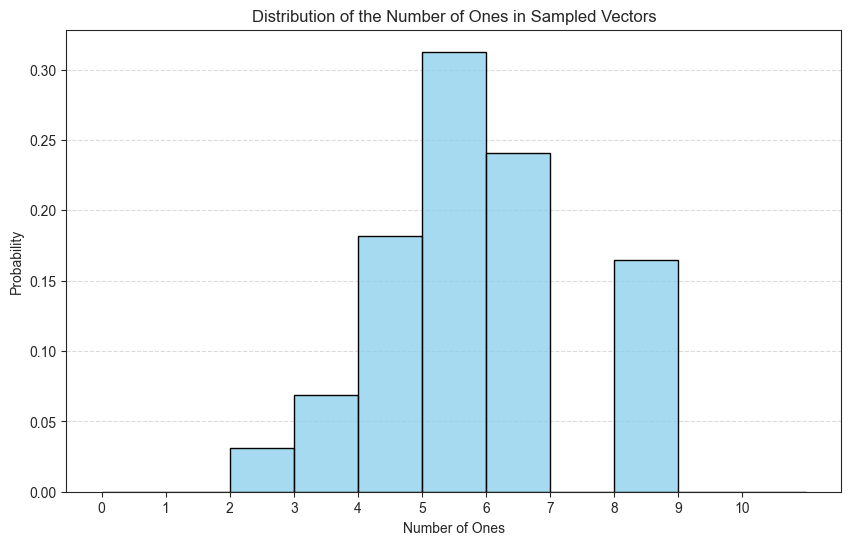

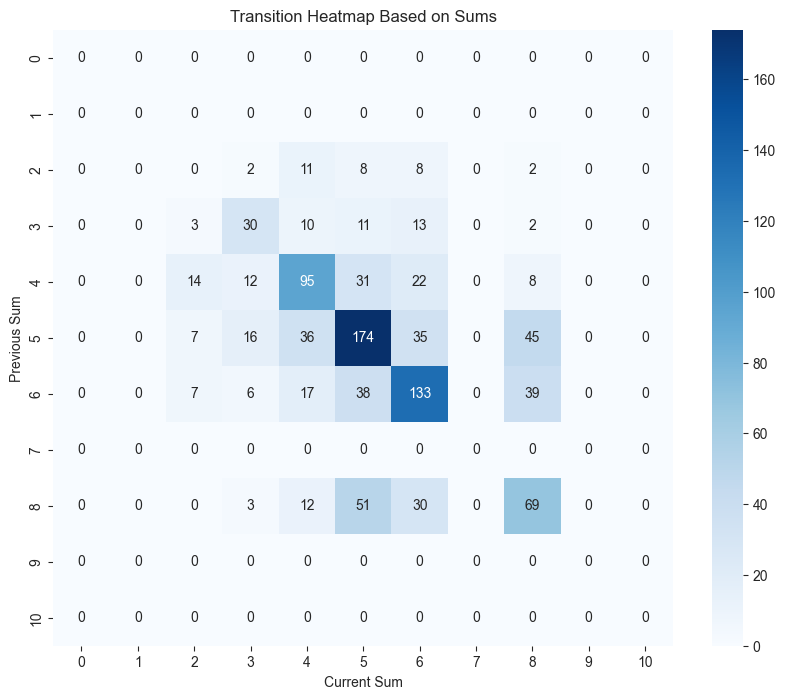

In [218]:

def plot_transition_heatmap(Z,  samples, title="Transition Heatmap Based on Sums"):
    """
    Plot a heatmap showing the transitions between different sums of the binary vectors.
    Each cell (i, j) in the heatmap represents the number of times the chain moved from a state with sum i to a state with sum j. 

    Parameters:
    - Z (np.ndarray): The support matrix.
    - samples (list): List of sampled state indices.
    - title (str): Title of the plot.
    """
    # Compute the sum of each sampled state
    sums = [Z[idx].sum() for idx in samples]
    
    # Compute transitions
    transitions = {}
    for i in range(1, len(sums)):
        prev_sum = sums[i-1]
        curr_sum = sums[i]
        transitions[(prev_sum, curr_sum)] = transitions.get((prev_sum, curr_sum), 0) + 1
    
    # Prepare data for heatmap
    max_sum = Z.shape[1]
    heatmap_data = np.zeros((max_sum+1, max_sum+1), dtype=int)
    for (prev, curr), count in transitions.items():
        heatmap_data[prev, curr] = count
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(0, max_sum+1), 
                yticklabels=range(0, max_sum+1))
    plt.title(title)
    plt.xlabel('Current Sum')
    plt.ylabel('Previous Sum')
    plt.show()
    
def plot_sum_distribution(Z, samples, title="Distribution of the Number of Ones in Sampled Vectors"):
    """
    Plot a histogram of the number of ones in the sampled vectors.

    Parameters:
    - Z (np.ndarray): The support matrix.
    - samples (list): List of sampled state indices.
    - title (str): Title of the plot.
    """
    sums = [Z[idx].sum() for idx in samples]
    plt.figure(figsize=(10, 6))
    sns.histplot(sums, bins=range(0, Z.shape[1]+2), kde=False, stat='probability', color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of Ones')
    plt.ylabel('Probability')
    plt.xticks(range(0, Z.shape[1]+1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
def plot_state_proportion(states_idx):
    plt.figure(figsize=(15,14))
    sns.histplot(states_idx, bins=range(0, Z.shape[1]+2), stat='proportion')
    plt.xticks(range(0, Z.shape[1]+1))
    plt.xlabel('State');
    sns.despine()

plot_state_proportion(states_idx)
plot_sum_distribution(Z, samples=states_idx)
plot_transition_heatmap(Z, samples=states_idx)
